# Inicialización de Python

## Instalación de Paquetes Necesarios

* `nibabel` 
* `dipy`
* `fury`
* `pytest` 
* `nose`

In [ ]:
!pip install nibabel dipy fury pytest nose

# Funciones Auxiliares

## Manejo de Imagenes

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def eqhist(img,nbins):
    """ Histogram equalization. """
    # Compute histogram
    hist,bins = np.histogram(img.flatten(),nbins)
    csum = hist.cumsum()
    csum = 255.0 * csum / csum[-1] # normalize by the max # Linear interpolation of csum
    im2 = np.interp(img.flatten(),bins[:-1],csum)
    return im2.reshape(img.shape)

def print_images(images, n=1, m=1, title='', flag=False, nbins=512): # Falta solucionar caso n=m=1
    """
    Imprime las imagenes con su correspondiente titulo en un grid de n por m
    Args:
        images (list(np.ndarray)): Imagenes a imprimir.
        n (int): Cantidad de filas.
        m (int): Cantidad de columnas.
    """
    images = images[:n*m]
    if n == 1 and m == 1 :
        plt.imshow(image,vmin=image.min(), vmax=image.max(), cmap='gray')
    else:
        fig, axs = plt.subplots(
            nrows=n, ncols=m, 
            figsize=(12, 8), 
            subplot_kw={
                'xticks': [], 
                'yticks': []
            }
        )
        for ax, image in zip(axs.flat, images):
            #vmin = image.min()
            #vmax = image.max()
            #image = (np.float64(image)-vmin)/(vmax-vmin)
            if flag : image = eqhist(image, nbins)
            ax.imshow(image,vmin=image.min(), vmax=image.max(), cmap='gray')
            ax.set_title(title)
    plt.tight_layout()
    plt.show()

def print_graphs(graphs, n=1, m=1, title=''):
    """
    Imprime las graficas con su correspondiente titulo en un grid de n por m
    Args:
        graphs (list(np.ndarray)): Graficas a imprimir.
        n (int): Cantidad de filas.
        m (int): Cantidad de columnas.
    """

    graphs = graphs[:n*m]
    if n == 1 and m == 1 :
        plt.imshow(image,vmin=image.min(), vmax=image.max(), cmap='gray')
    else:
        fig, axs = plt.subplots(
            nrows=n, ncols=m, 
            figsize=(12, 8), 
        )
        for ax, graph in zip(axs.flat, graphs):
            ax.plot(graph)#, cmap='gray')
            ax.set_title(title)
    plt.tight_layout()
    plt.show()

## Clase Volumen de RM

Una implementacion propia para faciliar manejo del volumen de RM.

In [ ]:
from scipy.optimize import curve_fit

class MR_Volume():

    # Se puede definir un volumen de voxeles (i,j,k) que dependa de TR y TE
    
    # Dado TR y TE, se hace una correspondencia con un volumen (i,j,k) calculado
    # con estos parametros.

    # Dado (i,j,k) y un TE se devuelve el conjunto de valores para cada TR
    # Dado (i,j,k) y un TR se devuelve el conjunto de valores para cada TE

    def __init__(self, volume, TR=[], TE=[], ITKSNAP_VIEW = True):
        """
        Parametros:
            volume (numpy.ndarray): Volumen de RM de una misma tajada de tejido
            TR (list(int)): Valores de TR con los que se construyo el volumen 
            TE (lidt(int)): Valores de TE con los que se construyo el volumen
            ITKSnap_VIEW (bool): Indica orientacion de volumen para 
                            correspondencia de visualizaciones de ITK-Snap
        """
        # Si queremos que las visualizaciones aparezcan orientadas como ITK-Snap
        if ITKSNAP_VIEW :
            volume = volume[:,::-1,:]
            volume = np.transpose(volume, (1, 0, 2))

        tr_n_slices = len(TE) # A cada TR le tocan len(TE) datos
        te_n_slices = len(TR) # A cada TE le tocan len(TR) datos
        
        # Mapeo de valores TR a lista de indices correspondientes a ese TR 
        tr_to_te_list = dict({})
        for tr_index, tr in enumerate(TR):
            tr_to_te_list[tr] = [ 
                tr_index*tr_n_slices + te_index
                for te_index, te in enumerate(TE)
            ]
        # Mapeo de valores TE a lista de indices correspondientes a ese TE
        te_to_tr_list = dict({}) # Llaves son valores TE
        for te_index, te in enumerate(TE):
            te_to_tr_list[te] = [ 
                tr_index*tr_n_slices + te_index 
                for tr_index, tr in enumerate(TR)
            ]

        # Reacomodamos para tener los TR's en orden crediente
        #for te in TE : self.te_map[te].reverse()

        self.tr_n_slices = tr_n_slices
        self.te_n_slices = te_n_slices
        self.tr_to_te_list = tr_to_te_list
        self.te_to_tr_list = te_to_tr_list
        self.volume = volume
        self.TR = TR
        self.TE = TE

        n_rows, n_cols, n_slices = volume.shape

        self.total_slices = n_slices
        self.n_rows = n_rows
        self.n_cols = n_cols
    
    """ Conversion de pareja de valores (TR,TE) a indice """
    def tr_te_to_index(self, tr, te):
        ans = list(set(self.tr_to_te_list) & set(self.te_to_tr_list))
        return ans[0]

    """ Dado un indice de tajada devolvemos TR y TE correspondientes """
    def index_to_tr_te(self, index):
        te_index = index % self.te_n_slices
        tr_index = index // self.tr_n_slices
        return TR[tr_index], TE[te_index]    
    
    """ Dimensiones del volumen de RM """
    def get_total_slices(self):return self.total_slices
    def get_n_rows(self):return self.n_rows
    def get_n_cols(self):return self.n_cols

    """ Mapeos TR-TE a lista de indices correspondientes """
    def get_indices_from_TR(self, tr):return self.tr_to_te_list[tr]
    def get_indices_from_TE(self, te):return self.te_to_tr_list[te]

    """ Peticion de tajada dado un indice """
    def get_slice_from_index(self, index):
        return self.volume[ : , : , index ]
    def get_slices_from_indices(self, indices):
        slices = [self.volume[ : , : , index ] for index in indices]
        return slices

    """ 
    Peticion de valores de voxeles correspondiente a tajada en i,j
    para un determinado tiempo TE fijo y variando sobre TR. 
    """
    def get_values_from_ij_TE(self, i, j, te):
        # Calculamos los indices de tajas que involucran al valor TE = te
        te_indices = self.te_to_tr_list[te]
        # Devolvemos pixel en i,j de todas las imagenes con TE = te
        return self.volume[i,j,te_indices]

    """ 
    Peticion de valores de voxeles correspondiente a tajada en i,j
    para un determinado tiempo TR fijo  y variando sobre TE.
    """
    def get_values_from_ij_TR(self, i, j, tr):
        # Calculamos los indices de tajas que involucran al valor TR = tr
        tr_indices = self.tr_to_te_list[tr]
        # Devolvemos pixel en i,j de todas las imagenes con TR = tr
        return self.volume[i,j,tr_indices]

    """ Listas de TR's y TE's """    
    def get_TE_list(self) : return self.TE
    def get_TR_list(self) : return self.TR

    def get_T1(self) : pass
    def get_T2(self) : pass

# Conjunto de datos

Trabajamos con un volúmen de RM compuesto por varias muestras de una tajada del cerebro de una rata. 

## Objetivos

* Para cada voxel estimar $T1, T2$ y $M_0$

## Contexto
El volumen de Resonancia Magnética resulta de tomar una imagen de RM de una tajada dedimensionesl cerebro de una rata con diferentes Tiempos Eco (TE) y diferentes Tiempos de Repetición (TR).

## Contenido

El volumen contiene $$R \times C \times S = 180 \times 230 \times 30$$ voxeles, donde 

* $R$ y $C$ son la cantidad de voxeles por cada fila y cada columna de la tajada respectivamente.
* $S$ es el número de muestras de la misma tajada.

Tiempos de Repetición $$TR = [200, 400, 800, 1500, 3000, 5000]$$
Tiempos Eco $$TE = [7, 21, 35, 49, 63]$$


## Lectura y almacenamiento de datos

In [ ]:
path = '20181018_140750T1T2mapRAREs60001a001.nii'

Usamos función `load_nifti`:

* `data` es `numpy.ndarray` de `numpy.float64`. Es el volumen de RM.
* `img` es `nibabel.nifti1.Nifti1Image`. Solo lo usamos para llamar a `get_zooms()`.

In [ ]:
from dipy.io.image import load_nifti

data, affine, img = load_nifti(path, return_img=True)

In [ ]:
print(img.header.get_zooms())

(0.13043478, 0.14222223, 1.0)


In [ ]:
TR = [5000, 3000, 1500, 800, 400, 200]
TE = [7, 21, 35, 49, 63]

In [ ]:
mr_volume = MR_Volume(volume = data, TR = TR, TE = TE)

n_rows = mr_volume.get_n_rows()
n_cols = mr_volume.get_n_cols()

print(n_rows, n_cols)

180 230


## Algunas visualizaciones

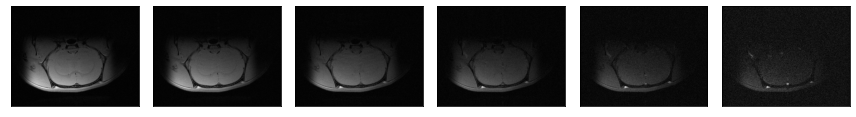

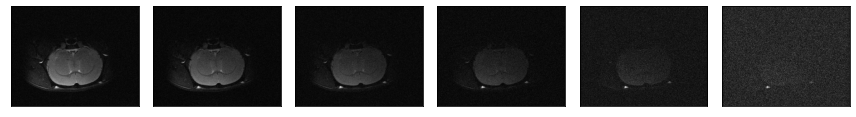

In [ ]:
slices = mr_volume.get_slices_from_indices([0, 5, 10, 15, 20, 25])
print_images(slices, 1, 6)

slices = mr_volume.get_slices_from_indices([4, 9, 14, 19, 24, 29])
print_images(slices, 1, 6)

# Consideraciones y observaciones iniciales para ajuste de modelo

## Consideraciones para estimación de $PD$

Al usar un Tiempo de Repetición ($TR$) largo y un Tiempo Eco corto ($TE$) obtenemos una señal está ponderada en Densidad de Protones ($PD$), es decir nuestra señal aproxima $M_0$.

El mayor valor disponible $TR$ es $5000$ y el menor valor $TE$ es $7$, por lo que la señal obtenida con estos valores debe aproximar $M_0$.

* La primera imagen corresponde a $TR = 5000$ y $TE = 7$, por lo que la señal está ponderada en $PD$.
* La segunda imagen corresponde a $TR = 3000$ y $TE = 7$, por lo que la señal está ponderada en $PD$.

Podemos notar valores $M_0$ parecidos. Notamos en particular una considerable densidad de protones en la estructura con forma de W en la parte inferior.

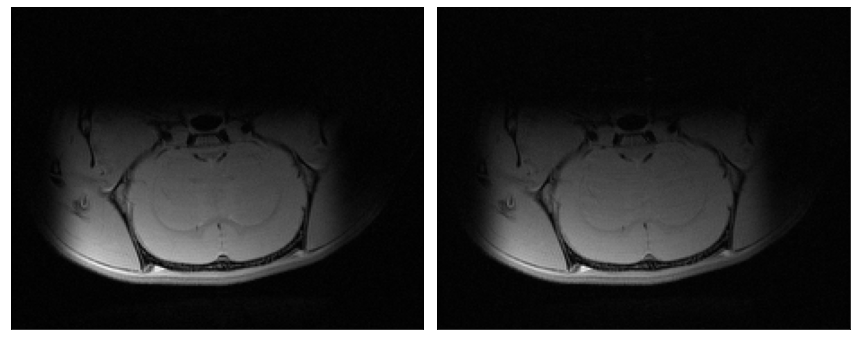

In [ ]:
indices = [0, 5]

print_images(mr_volume.get_slices_from_indices(indices), 1, 2)

### Estimación inicial de $M_0$

Dado que la señal correspondiente a estos parámetros $TR$ y $TE$ aproxima al valor $M_0$ de cada voxel, usamos como parámetro inicial de cada voxel al ajustar modelos más adelante.

In [ ]:
initial_M0 = mr_volume.get_slice_from_index(0) # Primera aproximacion de M_0

## Consideraciones para estimación de $T1$

Queremos estimar el valor de $T1$ de cada voxel de tejido. Para esto usamos un valor de $TE$ lo suficientemente pequeño para minimizar el efecto $T2$, esto es $$e^{ -TE/T2 } \approx 1$$ por lo que nuestra señal es $$M_{z}(t) \approx M_0 (1 - e^{-t/T2}) $$ El menor valor disponible es $TE = 7$, por lo que elegimos fijar este valor y variar los valores de $TR$.

In [ ]:
te_fixed = 7 # Para estimacion de T1

### Algunas visualizaciones y observaciones

* La primera imagen corresponde a $TR = 800$ y $TE = 7$, por lo que se espera una señal ponderada en $T1$.
* La segunda imagen corresponde a $TR = 200$ y $TE = 7$ por lo que pixeles brillantes corresponden a voxeles con un $T1$ pequeño, pues a pesar de tener poco tiempo $TR$ logran magnetizacion longitudial considerable.

De estas imágenes podemos hacer algunas observaciones

* De la segunda imagen podemos intuir que los tres pequeños cúmulos inferiores presentan un valor $T1$ alto. Por otro lado, observando la primera imagen con un tiempo $TR$ mayor y comparando estos tres puntos podenos notar que el cúmulo central inferior tiene un valor $T1$ mayor que los otros dos, pues su brillo decae más rápido (El valor de $T1$ es pequeño pero no tan pequeño como el valor de los otros dos).

* De las dos imagenes notamos que las regiones externas a la region central tienen un valor $T1$ parecido, pues el brillo de estas regiones es casi uniforme en ambas imagenes.

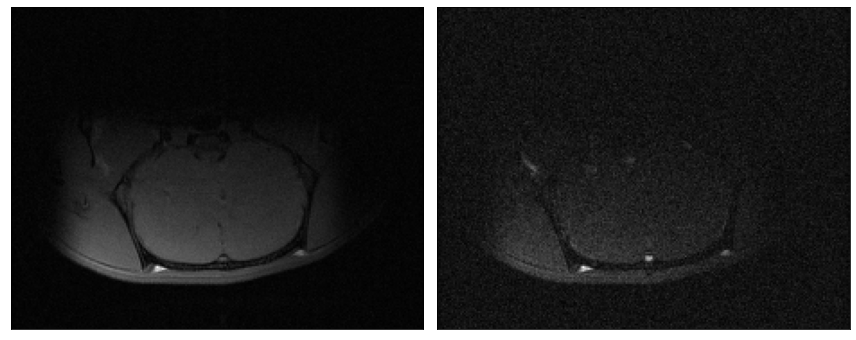

In [ ]:
indices = [15, 25] # Inidices correspondientes a TE = 7

print_images(mr_volume.get_slices_from_indices(indices), 1, len(indices))

### Estimación inicial de $T1$

Usando una imagen ponderada en $T1$ y la aproximación a $M_0$ calculamos para otorgar un valor inicial $T1$ a algoritmo de optimización del ajuste de modelo.

In [ ]:
t1_weighted = mr_volume.get_slice_from_index(15) # TR, TE = 800, 7

# Despejamos T1
t1_weighted = t1_weighted / initial_M0
t1_weighted[t1_weighted >= 1.0 ] = 0.99999 # Para evitar errores con voxeles sin tejido
t1_weighted = np.log(np.ones(t1_weighted.shape) - t1_weighted)

initial_T1 = -800*(np.ones(t1_weighted.shape) / t1_weighted)

## Consideraciones para estimación de $T2$

Queremos estimar el valor de $T2$ de cada voxel de tejido. Para esto usamos un valor de $TR$ lo suficientemente grande para minimizar el efecto $T1$, esto es $$1 - e^{ -TR/T1 } \approx 1$$ por lo que nuestra señal es $$M_{xy}(t) \approx M_0 e^{-t/T2} $$ El mayor valor disponible es $TR = 5000$, por lo que elegimos fijar este valor y variar los valores de $TE$.

In [ ]:
tr_fixed = 5000 # Para estimacion de T2

### Algunas visualizaciones y observaciones

* La primera imagen corresponde a $TR = 5000$ y $TE = 7$, por lo que la señal está ponderada en $PD$.
* La segunda imagen corresponde a $TR = 5000$ y $TE = 63$, por lo que la señal está ponderada en $T2$.

De estas imágenes podemos hacer algunas observaciones

* De la seunda imagen podemos notar que la región central y los cuatro pequeños cumulos en los extremos presentan un valor de $T2$ mayor que las regiones externas.
* Notemos que en el centro de la región en forma de W presenta un nivel de gris medio en la imagen izquierda, pero en la imagen derecha esta zona está negra, por lo que la caída de señal fué alta, es decir, el valor de $T2$ es chico en esta pequeña región.

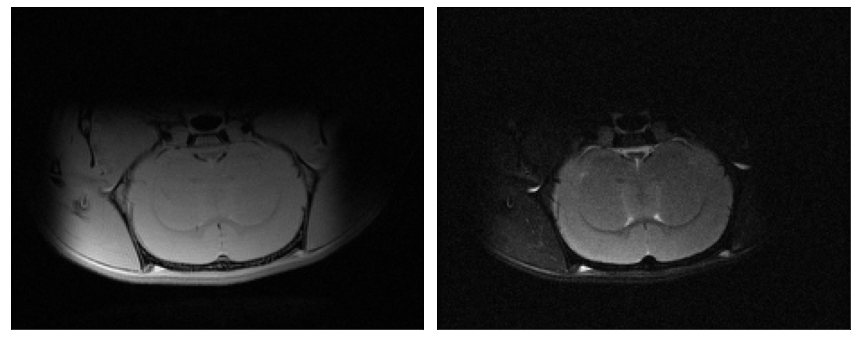

In [ ]:
indices = [0,4] # Inidices correspondientes a TR = 5000 con TE=7 y TE=63

print_images(mr_volume.get_slices_from_indices(indices), 1, len(indices))

En las siguientes dos imagenes corresponden a tiempos $TR$ pequeños y $TE$ largos, por lo que voxeles con señal alta presentan valores $T1$ pequeños (Magnetizacion longitudinal rapida) y/o $T2$ largos (Decadencia de magnetización transversal).

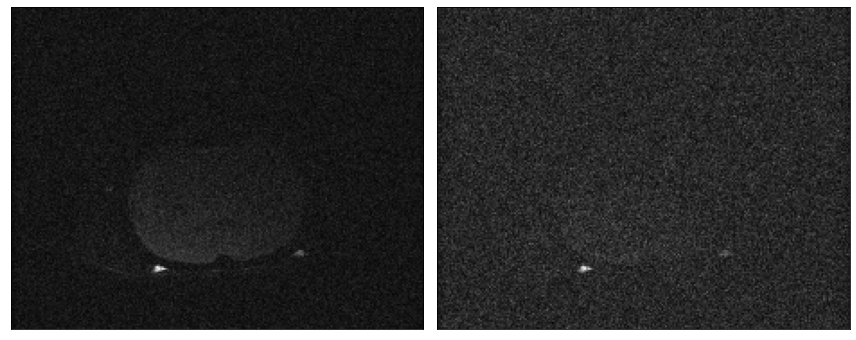

In [ ]:
indices = [24,29] # Inidices correspondientes a (TR, TE) = (400, 63) y (200, 63)

print_images(mr_volume.get_slices_from_indices(indices), 1, len(indices))

### Estimación inicial de $T2$

Usando una imagen ponderada en $T2$ y la aproximación a $M_0$ calculamos para otorgar un valor inicial $T2$ a algoritmo de optimización del ajuste de modelo.

In [ ]:
t2_weighted = mr_volume.get_slice_from_index(4) # TR, TE = 5000, 63

# Despejamos T2
t2_weighted = t2_weighted / initial_M0
t2_weighted[t2_weighted <= 0.0 ] = 0.0001 # Para evitar errores con voxeles sin tejido
t2_weighted = np.log(t2_weighted)
t2_weighted[abs(t2_weighted) <= 0.00001] = 0.00001

initial_T2 = -63*(np.ones(t2_weighted.shape) / t2_weighted)

# Ajuste de Modelos

## Modelo T2


### Modelo y Parámetros iniciales
Buscamos constantes $M_0$ y $T2$ en $$M(t) = M_0 e^{-t/T2}$$

* Usamos como parámetro inicial para nuestro algoritmo de optimizacion un valor de $T2 = 100.0ms$.
* Dado que el agua tiene un valor de $T2$ del orden de milisegundos, usamos como cota superior $T2_\text{MAX} = 2seg$, recordando que el agua tiene un $T2 \approx 1seg$.
* Usamos como cota superior para $M_0$ un $M_\text{MAX} = 1000.0$

In [ ]:
initial_uniform_T2 = 100.0
T2_MAX = 2000.0
initial_T2[initial_T2 > T2_MAX] = T2_MAX - 1.0
initial_T2[initial_T2 < 0.1] = 0.2

M0_MAX = 1000.0

In [ ]:
def model_T2(t,  M0, T2):
    return M0 * np.exp(- (np.array(t) / T2) )

### Estimación de $M_0$ y $T2$

In [ ]:
T2_values = np.zeros((n_rows, n_cols), dtype=np.float64)
M_t2 = np.zeros((n_rows, n_cols), dtype=np.float64)
for i in range(n_rows):
    if i %10 == 0 : print(i)
    for j in range(n_cols):

        te_values = mr_volume.get_values_from_ij_TR(i, j, tr_fixed)

        try:
            popt, pcov = curve_fit(
                model_T2, xdata = TE, ydata = te_values,
                p0=[initial_M0[i,j], initial_T2[i,j]],
                bounds=(0.1, [M0_MAX, T2_MAX])
            )
        except RuntimeError:
            print('Error - curve_fit failed: ' + str(i) + "," + str(j))
            popt = [0.1, 0.1]

        T2_values[i,j] = popt[1]
        M_t2[i,j] = popt[0]

#plt.plot(TE, mr_volume.get_TE_from_TR(i, j, tr_fixed), 'b-', label='data')
#plt.show()
#x = np.linspace(0, 1000, 100)
#plt.plot(x, model_T2(x, popt[0], popt[1]), 'r-')
         #label='fit: a=%5.3f, b=%5.3f' % tuple(popt))

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170


#### Resultados $M_0$

* Primera imagen corresponde a señal con $TR = 5000$ y $TE = 7$ ponderada en $PD$.
* Segunda imagen corresponde a mapa de valores $M_0$ de cada voxel.

Podemos notar que ambas imágenes se parecen pero si observamos el cúmulo central inferior (En medio de la estructura con forma de W) notamos que en la primera imagen esta pequeña zona es menos clara que en la segunda, por lo que tenemos un caso de densidad de protones __alta__ pero magnetización longitudinal muy rápida ($T1$ pequeño), que concuerda con observaciones previas.

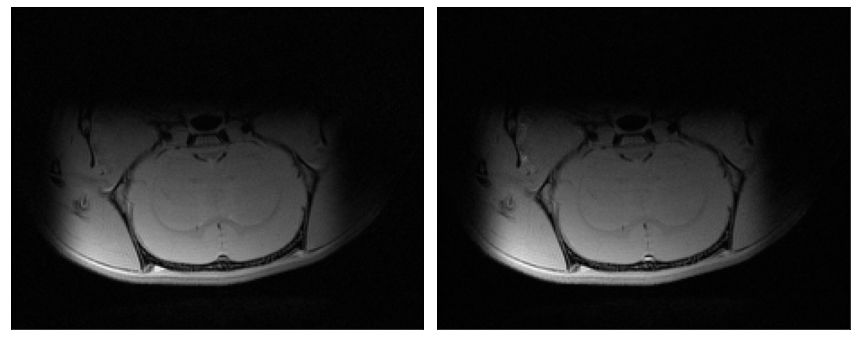

In [ ]:
print_images([initial_M0, M_t2], 1, 2)

In [ ]:
print(M_t2.min(), M_t2.max())

0.39424571790732443 116.77897852902503


#### Resultados $T2$


* La imagen izquierda corresponde al mapa de $T2$ calculado, al cual se le aplicó una ecualización de histograma para lograr apreciar el contraste en la zona del cerebro. Podemos notar que hay presencia de ruido en las zonas exteriores al cerebro.
* La imagen derecha corresponde al mapa de $T2$ calculado. La imagen parece negra debido a que fuera de las zonas cerebrales el $T2$ calculado es muy grande (lo mayor posible) debido a que la señal es cercana a cero y se mantiene así en todo momento, por lo que al optimizar, ese comportamiento se interpreta como una caída de señal muy lenta.

Algunas observaciones de las imagenes

* De la imagen izquierda podemos notar que en su zona central el valor $T2$ es mayor que la zona con forma de W y que la zona exterior. La zona central pertenece a materia gris del cerebro, que sabemos tiene un valor $T2$ mayor a la materia blanca, la cual ocupa la zona con forma de W. También podemos apreciar que la zona externa al cerebro pertenece a músculo, y recordamos que tiene un valor $T2$ menor a la materia gris y blanca.
* Notemos en la imagen izquierda que la zona central de la región con forma de W es negra, por lo que tiene un valor de $T2$ pequeño que concuerda con observaciones anteriores.

Por lo tanto los resutados concuerdan con observaciones previas.

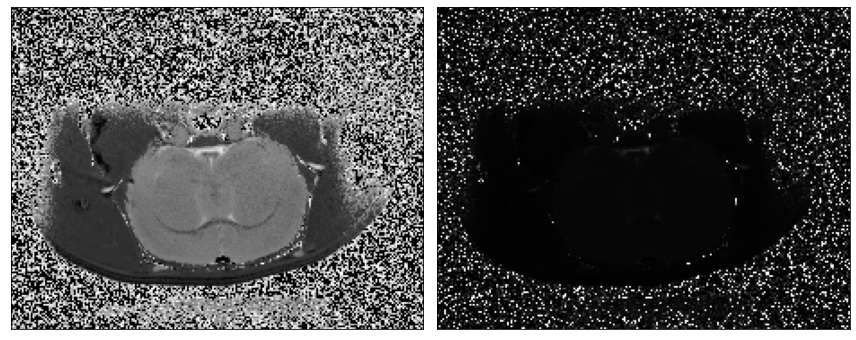

In [ ]:
print_images([eqhist(T2_values, 256), T2_values], 1, 2)

##### Otras visualizaciones
Definiremos en un punto de corte y asignamos a los voxeles con $T2$ mayor, un $T2$ pequeño. Para esto usamos el histograma.

1999.9999999999998 0.2 199.43303361654435


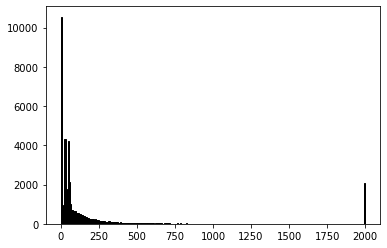

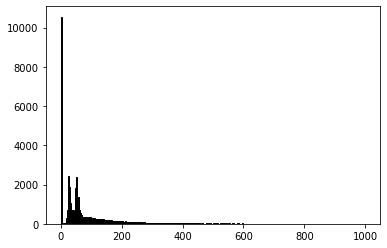

In [ ]:
print(T2_values.max(), T2_values.min(), T2_values.mean())

plt.hist(T2_values.ravel(), bins=256, range=(0.0, 2000), fc='k', ec='k') 
plt.show()

plt.hist(T2_values.ravel(), bins=256, range=(0.0, 1000), fc='k', ec='k') 
plt.show()

799.8083660298321 0.2 79.30066540273987


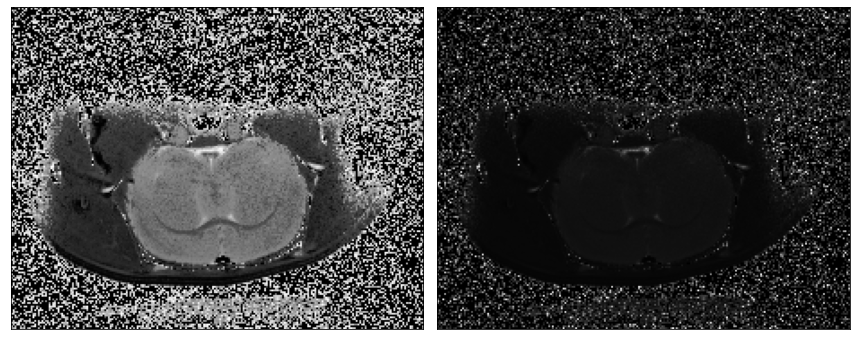

In [ ]:
T2_val = T2_values.copy()
T2_val[ T2_val > 800.0 ] = 1.0 # Aqui de seguro voy a equivocarme con voxeles de agua
print(T2_val.max(), T2_val.min(), T2_val.mean())
print_images([eqhist(T2_val, 256), T2_val], 1, 2)

### Reconstrucción de imagenes usando valores $M_0$ y $T2$ calculados

93.97061250162677 2.485765283593653e-16


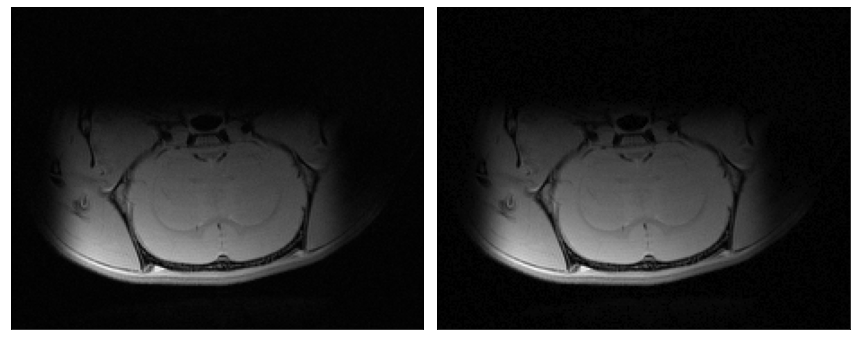

In [ ]:
te = 7
image_recover = np.zeros((n_rows, n_cols), dtype=np.float64)
for i in range(n_rows):
    for j in range(n_cols):
        image_recover[i,j] = model_T2(te, M_t2[i,j], T2_values[i,j])

print(image_recover.max(), image_recover.min())
print_images([mr_volume.get_slice_from_index(0), image_recover], 1, 2)

35.4488558670385 6.208764473712772e-138


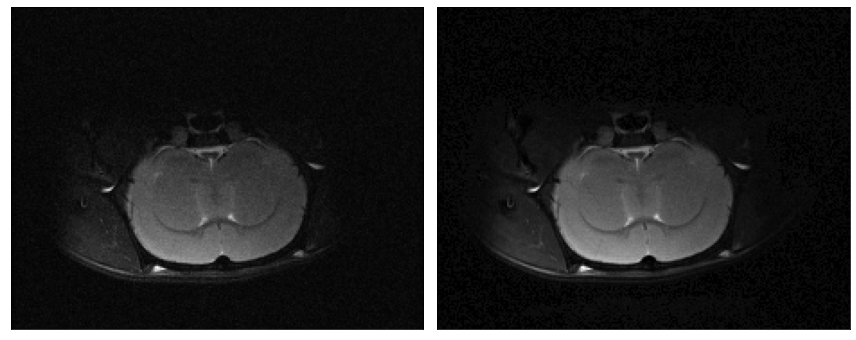

In [ ]:
te = 63
image_recover = np.zeros((n_rows, n_cols), dtype=np.float64)
for i in range(n_rows):
    for j in range(n_cols):
        image_recover[i,j] = model_T2(te, M_t2[i,j], T2_values[i,j])

print(image_recover.max(), image_recover.min())
print_images([mr_volume.get_slice_from_index(4), image_recover], 1, 2)

## Modelo T1

### Modelo y Parámetros iniciales

$$M(t) = M_0 (1 - e^{-t/T1})$$

* Usamos como parámetro inicial para nuestro algoritmo de optimizacion un valor de $T1 = 1seg$.
* Dado que los valores de $T1$ son del orden de segundos, usamos como cota superior $T1_\text{MAX} = 10seg$.
* Usamos como cota superior para $M_0$ un $M_\text{MAX} = 1000.0$

In [ ]:
initial_uniform_T1 = 1000.0
T1_MAX = 10000.0
initial_T1[initial_T1 > T1_MAX] = T1_MAX - 1.0
initial_T1[initial_T1 < 1.0] = 1.0

M0_MAX = 1000.0

In [ ]:
def model_T1(t, M0, T1):
    return M0 * (1 - np.exp(- (np.array(t)) / T1) )

### Estimación de $M_0$ y $T1$

In [ ]:
T1_values = np.zeros((n_rows, n_cols), dtype=np.float64)
M_t1 = np.zeros((n_rows, n_cols), dtype=np.float64)
for i in range(n_rows):
    if i %10 == 0 : print(i)
    for j in range(n_cols):

        tr_values = mr_volume.get_values_from_ij_TE(i, j, te_fixed)

        try:
            popt, pcov = curve_fit(
                model_T1, xdata = TR, ydata = tr_values,
                p0=[initial_M0[i,j], initial_T1[1,j]],
                bounds=(0.1, [M0_MAX, T1_MAX])
            )
        except RuntimeError:
            print('Error - curve_fit failed: ' + str(i) + "," + str(j))
            popt = [0.1, 0.1]

        T1_values[i,j] = popt[1]
        M_t1[i,j] = popt[0]
#plt.plot(TR, mr_volume.get_TR_from_TE(i, j, te_fixed), 'b-', label='data')
#plt.show()
#x = np.linspace(0, 1000, 100)
#plt.plot(x, model_T2(x, popt[0], popt[1]), 'r-')
         #label='fit: a=%5.3f, b=%5.3f' % tuple(popt))

0
Error - curve_fit failed: 6,224
10
20
30
Error - curve_fit failed: 32,56
40
50
60
70
80
Error - curve_fit failed: 84,219
90
Error - curve_fit failed: 94,212
100
110
120
130
140
150
160
170


#### Resultados $M_0$

* Primera imagen corresponde a señal con $TR = 5000$ y $TE = 7$ ponderada en $PD$.
* Segunda imagen corresponde a mapa de valores $M_0$ de cada voxel.

Si observamos el cúmulo central inferior (En medio de la estructura con forma de W) notamos que en la primera imagen esta pequeña zona es igual de clara que en la segunda, por lo que tenemos una contradicción de resultados comparando con el $M_0$ obtenido ajustando $T2$.

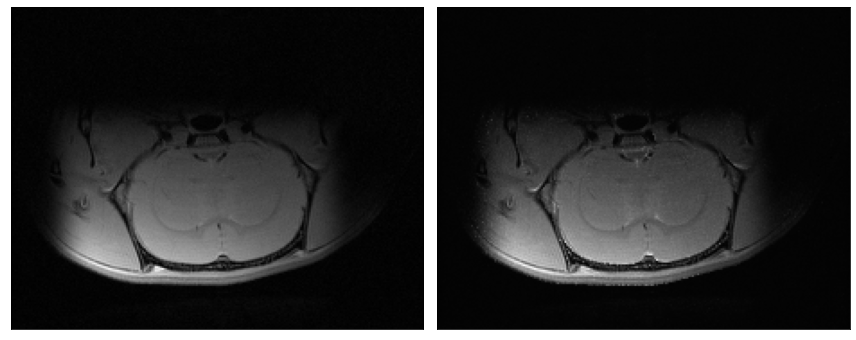

In [ ]:
print_images([initial_M0, M_t1], 1, 2)

In [ ]:
print(M_t1.max(), M_t1.min())

108.07099443182298 0.1


#### Resultados $T1$

* La imagen izquierda corresponde al mapa de $T1$ calculado, al cual se le aplicó una ecualización de histograma para lograr apreciar el contraste en la zona del cerebro. Podemos notar que hay presencia de ruido en las zonas exteriores al cerebro.
* La imagen derecha corresponde al mapa de $T1$ calculado.


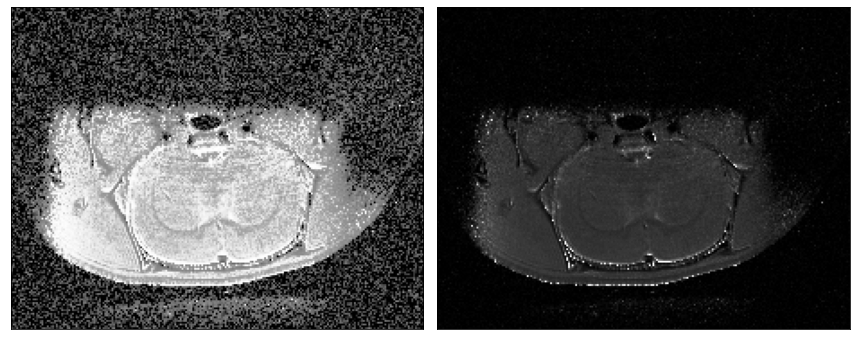

In [ ]:
print_images([eqhist(T1_values, 256), T1_values], 1, 2)

##### Otras visualizaciones

9999.999999999998 0.1 804.9110217340266


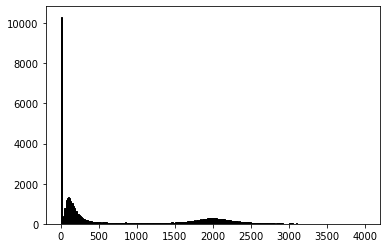

In [ ]:
print(T1_values.max(), T1_values.min(), T1_values.mean())

plt.hist(T1_values.ravel(), bins=256, range=(0.0, 4000), fc='k', ec='k') 
plt.show()

### Reconstrucción de imagenes a partir de $M_0$ y $T1$ calculados

94.35663237603666 0.1


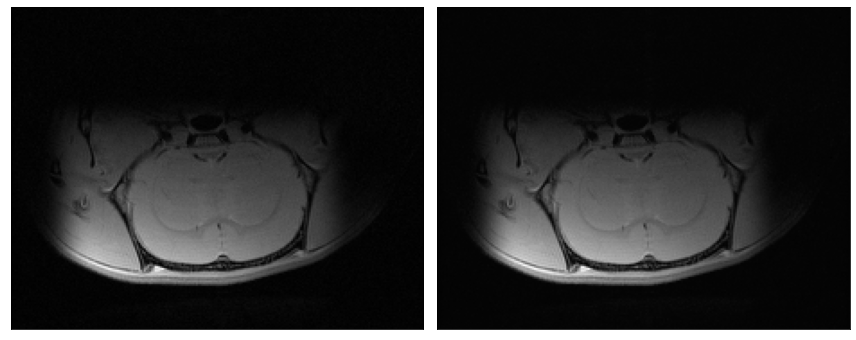

In [ ]:
tr = 5000
image_recover = np.zeros((n_rows, n_cols), dtype=np.float64)
for i in range(n_rows):
    for j in range(n_cols):
        image_recover[i,j] = model_T1(tr, M_t1[i,j], T1_values[i,j])

print(image_recover.max(), image_recover.min())
print_images([mr_volume.get_slice_from_index(0), image_recover], 1, 2)

38.477135728801706 0.1


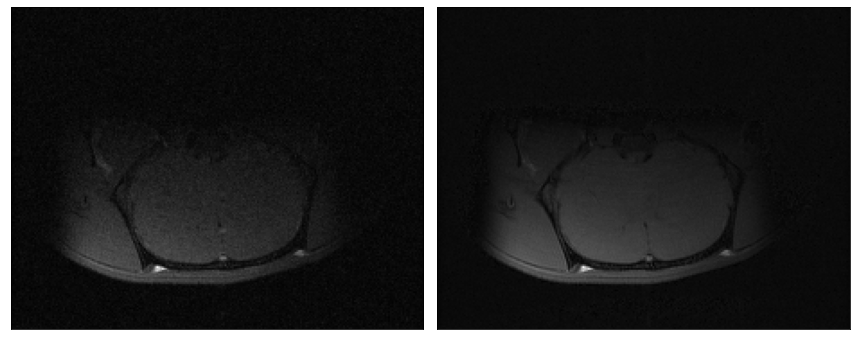

In [ ]:
tr = 400
image_recover = np.zeros((n_rows, n_cols), dtype=np.float64)
for i in range(n_rows):
    for j in range(n_cols):
        image_recover[i,j] = model_T1(tr, M_t1[i,j], T1_values[i,j])

print(image_recover.max(), image_recover.min())
print_images([mr_volume.get_slice_from_index(20), image_recover], 1, 2)

## Comparacion de $M_0$

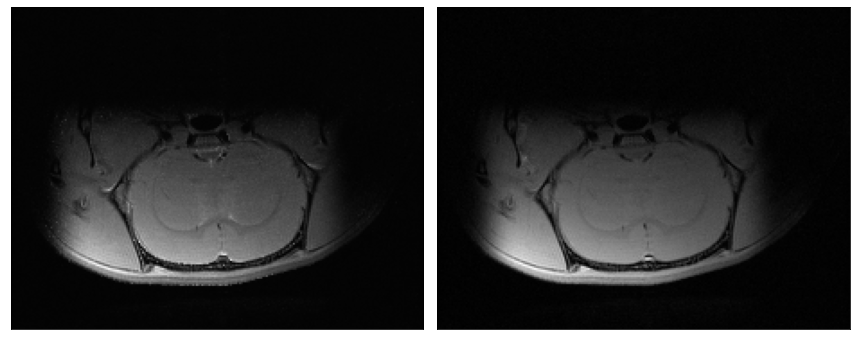

108.07099443182298 116.77897852902503
0.1 0.39424571790732443
10.178226784753043


In [ ]:
print_images([M_t1, M_t2], 1, 2)
print(M_t1.max(),M_t2.max())
print(M_t1.min(),M_t2.min())
print(np.mean((M_t1 - M_t2) ** 2))

# Reconstruccion a partir de parámetros obtenidos

La señal obtenida con un valor $TR$ y $TE$ está dada por $$M(t) = (1 - e^{-TR/T1}) M_0 (e^{-TE/T2})$$ Por lo que al multiplicar las señales de ambos modelos y quitar un factor $M_0$ aproximamos la señal obtenida con cualquier $TR$ y $TE$.

A continuación se presentan algunas reconstrucciones. Notemos que los resultados son parecidas a las muestras originales.

87.80792280231739 3.7057137343126245e-16


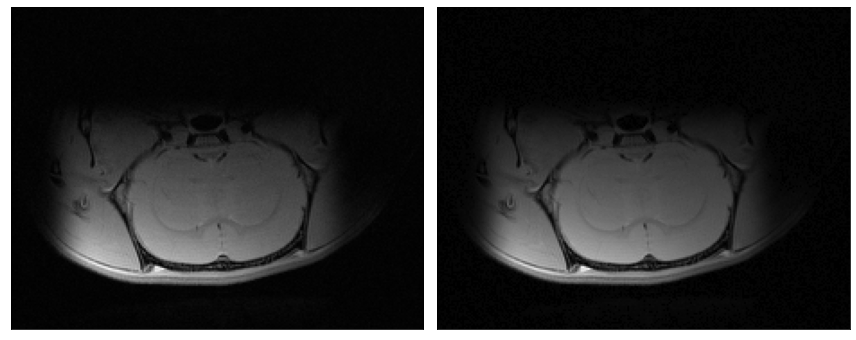

In [ ]:
tr = 5000
te = 7
image_recover = np.zeros((n_rows, n_cols), dtype=np.float64)
for i in range(n_rows):
    for j in range(n_cols):
        t1_signal = model_T1(tr, M_t1[i,j], T1_values[i,j])
        t2_signal = model_T2(te, M_t2[i,j], T2_values[i,j])
        m0_signal = (M_t1[i,j] + M_t2[i,j]) / 2.0
        image_recover[i,j] = ( t1_signal * t2_signal ) / (m0_signal)

print(image_recover.max(), image_recover.min())
print_images([mr_volume.get_slice_from_index(0), image_recover], 1, 2)

14.119516837521505 9.248777372859623e-138


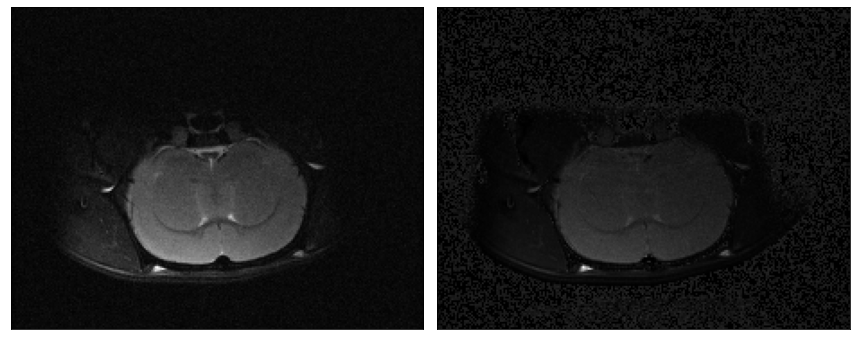

In [ ]:
tr = 400
te = 63
image_recover = np.zeros((n_rows, n_cols), dtype=np.float64)
for i in range(n_rows):
    for j in range(n_cols):
        t1_signal = model_T1(tr, M_t1[i,j], T1_values[i,j])
        t2_signal = model_T2(te, M_t2[i,j], T2_values[i,j])
        m0_signal = (M_t1[i,j] + M_t2[i,j]) / 2.0
        image_recover[i,j] = ( t1_signal * t2_signal ) / (m0_signal)

print(image_recover.max(), image_recover.min())
print_images([mr_volume.get_slice_from_index(4), image_recover], 1, 2)

35.558230524724515 5.85658089084391e-77


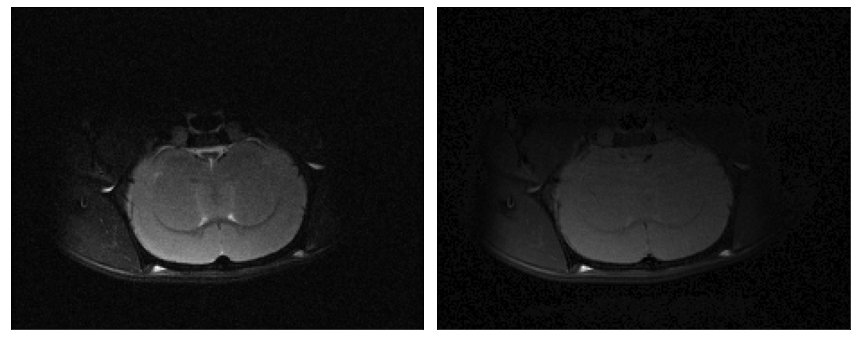

In [ ]:
tr = 800
te = 35
image_recover = np.zeros((n_rows, n_cols), dtype=np.float64)
for i in range(n_rows):
    for j in range(n_cols):
        t1_signal = model_T1(tr, M_t1[i,j], T1_values[i,j])
        t2_signal = model_T2(te, M_t2[i,j], T2_values[i,j])
        m0_signal = (M_t1[i,j] + M_t2[i,j]) / 2.0
        image_recover[i,j] = ( t1_signal * t2_signal ) / (m0_signal)

print(image_recover.max(), image_recover.min())
print_images([mr_volume.get_slice_from_index(4), image_recover], 1, 2)

# Mapas Finales Obtenidos

## Densidad de protones

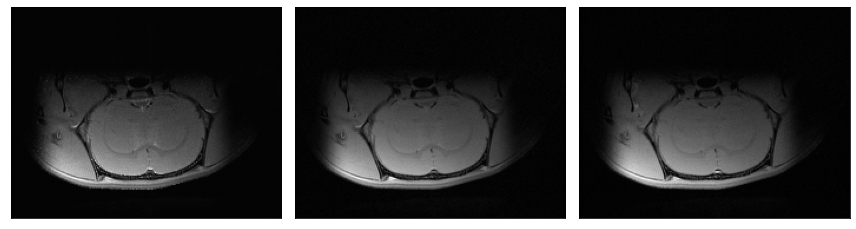

In [ ]:
print_images([M_t1, initial_M0, M_t2], 1, 3)

## Mapas de $T1$ y $T2$

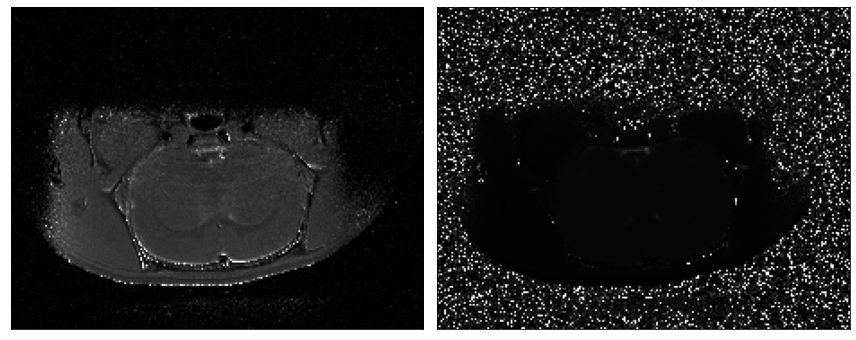

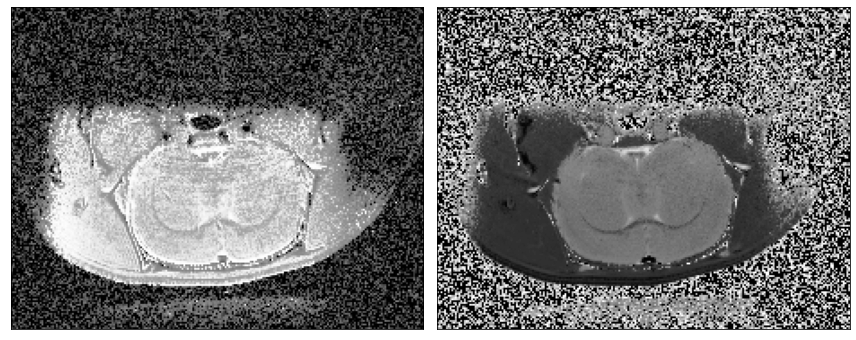

In [ ]:
print_images([T1_values, T2_values], 1, 2)
print_images([eqhist(T1_values, 256), eqhist(T2_values, 256)], 1, 2)

# Conclusiones

En resumen, en el presente proyceto:

* Se eligió un subconjunto de datos para estimar parámetros $M_0$ y $T1$, fijando un tiempo $TE$ pequeño y variando sobre $TR$. Se tiran los otros datos debido a que la señal de estos contiene mezclada la señal de $T2$, pero esto lo hago debido a falta de conocimiento en técnicas de análisis de datos.

* También se eligió un subconjunto de datos para estimar parámetros $M_0$ y $T2$, fijando un tiempo $TR$ pequeño y variando sobre $TE$. Se tiran los otros datos debido a que la señal de estos contiene mezclada la señal de $T1$.

* Para ajustar los modelos, se eligieron valores iniciales parecidos a los parámetros reales haciendo un análisis previo.

* Una vez obtenidos los valores $M_0$, $T1$ y $T2$, se reconstruyeron algunas imagenes para comparar visualmente resultados. Notamos que las imagenes recostruidas se parecen por lo que los valores son parecidos.

* A pesar del punto anterior podemos encontrar algunas inconsistencias en resultados: Al calcular densidad de protón en centro de region con forma de W obtenemos contrastes diferentes en ambos resultados.